# Importing Necessary libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
from sklearn.metrics import classification_report
import tensorflow as tf
import keras.utils as image


# Loading Dataset

In [3]:
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png


# Visualizing Dataset

In [ ]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1


In [122]:
print(f"Total IDC(-) images: {len(N_IDC)}")
print(f"Total IDC(+) images: {len(P_IDC)}")

Total IDC(-) images: 10000
Total IDC(+) images: 10000


In [123]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0':
        N_IDC.append(img)
    elif img[-5] == '1':
        P_IDC.append(img)



# Limit to 10,000 images each
N_IDC = N_IDC[:10000]
P_IDC = P_IDC[:10000]

# Data Preprocessing

In [124]:
non_img_arr = []
can_img_arr = []

for img in N_IDC:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

print(f"Processed IDC(-) images: {len(non_img_arr)}")
print(f"Processed IDC(+) images: {len(can_img_arr)}")

Processed IDC(-) images: 10000
Processed IDC(+) images: 10000


In [125]:
# Combine and shuffle the arrays
breast_img_arr = non_img_arr + can_img_arr
random.shuffle(breast_img_arr)

X = []
y = []

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [126]:
def describeData(a, b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b == 0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b == 1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))

describeData(X, y)


Total number of images: 20000
Number of IDC(-) Images: 10000
Number of IDC(+) Images: 10000
Image shape (Width, Height, Channels): (50, 50, 3)


In [127]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

Y = to_categorical(y, num_classes=2)

# Split data into training, testing, and validation sets (80% train, 10% validation, 10% test)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)


Training Data Shape: (16000, 50, 50, 3)
Validation Data Shape: (2000, 50, 50, 3)
Testing Data Shape: (2000, 50, 50, 3)


# Modeling

In [128]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0  # Import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [21]:

early_stop = EarlyStopping(monitor='val_loss', patience=5)

# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.3)(x)
x = Dense(24, activation='relu', kernel_initializer='he_uniform')(x)
output = Dense(2, activation='softmax')(x)

EfficientNetB0_model = Model(inputs=base_model.input, outputs=output, name="EfficientNetB0")

for layer in base_model.layers:
    layer.trainable = False

EfficientNetB0_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

EfficientNetB0_model.summary()


Model: "EfficientNetB0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 rescaling_2 (Rescaling)        (None, 50, 50, 3)    0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 50, 50, 3)   7           ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 50, 50, 3)    0           ['normalization_1[0]

In [ ]:

plot_model(EfficientNetB0_model, to_file='additional_layers_model_architecture.png', show_shapes=True, show_layer_names=True)

In [22]:
history = EfficientNetB0_model.fit(X_train, Y_train, epochs=20, batch_size=35, validation_data=(X_val, Y_val))

Epoch 1/20


2024-05-27 18:17:28.973777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


458/458 [==============================] - 16s 17ms/step - loss: 0.6183 - accuracy: 0.7123 - val_loss: 0.4794 - val_accuracy: 0.7725
Epoch 2/20
458/458 [==============================] - 6s 13ms/step - loss: 0.5020 - accuracy: 0.7720 - val_loss: 0.4504 - val_accuracy: 0.7910
Epoch 3/20
458/458 [==============================] - 6s 14ms/step - loss: 0.4755 - accuracy: 0.7858 - val_loss: 0.4280 - val_accuracy: 0.8025
Epoch 4/20
458/458 [==============================] - 6s 13ms/step - loss: 0.4545 - accuracy: 0.7951 - val_loss: 0.4180 - val_accuracy: 0.8065
Epoch 5/20
458/458 [==============================] - 6s 13ms/step - loss: 0.4438 - accuracy: 0.8017 - val_loss: 0.4140 - val_accuracy: 0.8155
Epoch 6/20
458/458 [==============================] - 6s 13ms/step - loss: 0.4335 - accuracy: 0.8050 - val_loss: 0.4063 - val_accuracy: 0.8100
Epoch 7/20
458/458 [==============================] - 6s 13ms/step - loss: 0.4230 - accuracy: 0.8106 - val_loss: 0.4065 - val_accuracy: 0.8230
Epoch 8/2

# Model Evaluation

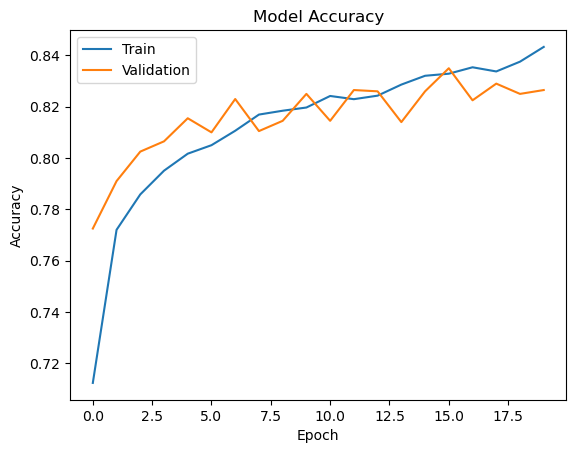

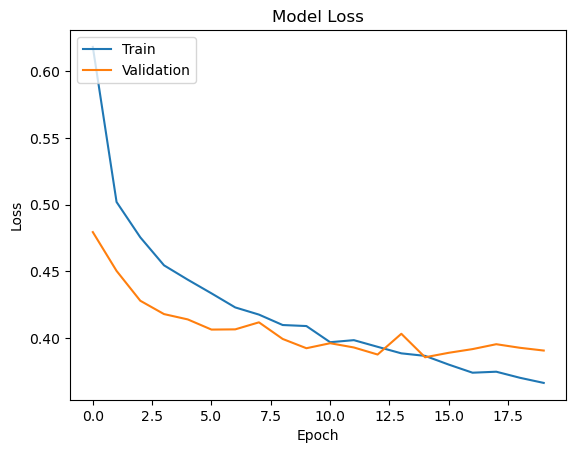

In [23]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



63/63 [==============================] - 2s 13ms/step
              precision    recall  f1-score   support

     Class 0    0.80632   0.84124   0.82341       970
     Class 1    0.84413   0.80971   0.82656      1030

    accuracy                        0.82500      2000
   macro avg    0.82523   0.82547   0.82499      2000
weighted avg    0.82579   0.82500   0.82503      2000



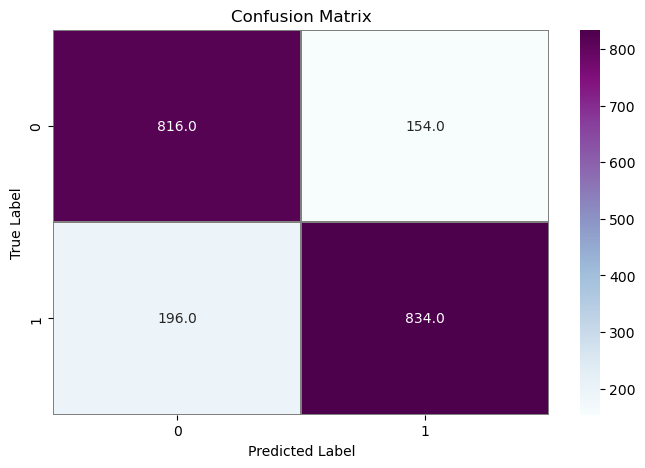

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

class_names = ['Class 0', 'Class 1']

# Predict classes for test set
Y_pred = EfficientNetB0_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

print(classification_report(Y_true, Y_pred_classes, target_names=class_names, digits=5))

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

confusion_mtx_percent = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis] * 100

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_mtx_percent, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Percentage)")
plt.show()


In [26]:
EfficientNetB0_model.evaluate(X_test,Y_test)

63/63 [==============================] - 1s 14ms/step - loss: 0.3868 - accuracy: 0.8250


[0.38679081201553345, 0.824999988079071]

# Model Save

In [ ]:
model.save("/kaggle/working/Brest CNN 2.h5")
